## Recurrent Neural Networks in PyTorch

The Recurrent Neural Network (RNN) Architecture, which can actually be seen as a strict generalization of standard MLPs is, alongside Convolutional Neural Networks, one of the classic Architectures of Neural Networks. 

In some sense, RNN's introduce a time component into the Neural Network by not needed to compute data in a single forward pass. For a basic Introduction see https://en.wikipedia.org/wiki/Recurrent_neural_network.

They also have many interesting Theoretical properties, like being able to model any Computable function :O  which we will not focus on. Because it is so widely used, there already exists a PyTorch implementation, for now, we will first see how we couldve implemented a RNN ourselves in PyTorch only using basic `nn.Parameter`.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
#basic RNN module with one hidden unit
class basicRNN(nn.Module):
    def __init__(self, input_dim,hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.act_hidden = nn.Tanh()
        #Sigmoid, since we work with normalized data we want to have outputs in [0,1]
        self.act_out = nn.Sigmoid()
        self.begin_grad = []
        self.end_grad = []
        self.middle_grad = []
        
        #init the parameters randomly, but make em smore for numerical stability
        self.in_hidden = nn.Parameter(torch.randn(hidden_dim,input_dim) * 0.01)
        self.hidden_hidden = nn.Parameter(torch.randn(hidden_dim,hidden_dim) * 0.01)
        self.hidden_out = nn.Parameter(torch.randn(output_dim,hidden_dim) * 0.01)
    
    def forward(self, x, h_t = None): 
        if h_t is None: 
            h_t = torch.zeros(self.hidden_dim) 
        
        
        out = []
        for t in range(x.size(0)):
            x_t = x[t] # value at current time-step
            #update hidden_state
            h_t = self.act_hidden(self.in_hidden @ x_t + self.hidden_hidden @ h_t)
            
            i = x.size(0)
            #hooking the gradients for tracking, to see vanishing grad problem later
            if t == 0: 
                h_t.register_hook(lambda grad: self.begin_grad.append(grad.norm().item()))          
            if i//2 == t: 
                h_t.register_hook(lambda grad: self.middle_grad.append(grad.norm().item()))          
            if i-1 == t:
                h_t.register_hook(lambda grad: self.end_grad.append(grad.norm().item()))          

            y = self.act_out(self.hidden_out @ h_t)
            out.append(y)
        out = torch.stack(out, dim = 0)
        return out, h_t   
    
#lets define our model
hidden_dim = 30
model = basicRNN(1, hidden_dim,1)
lossfunction = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)         
for p in model.parameters():
    print(p.shape)

torch.Size([30, 1])
torch.Size([30, 30])
torch.Size([1, 30])


### Training a Recurrent Neural Network

RNN's are particularly strong on tasks involving time, or other sequential data like text. We will give an example how one can train an RNN on time-series data, namely some stock ticker. For that, we will use the `yfinance` library https://pypi.org/project/yfinance/. Firstly, we will have to transform our our time-series we are given by `yfinance` into a suitable dataset with lables.

In [3]:
def create_dataset(time_series, seq_length):
        x,y = [], []
        for i in range(len(time_series)-seq_length):
            x.append(time_series[i:i+seq_length])
            y.append(time_series[i+seq_length])
        return torch.tensor(np.array(x), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)
    
ticker = "AAPL" 
start = "2021-01-01"
end = "2025-01-01"
data = yf.download(ticker, start, end)
#Lets only look at the closing prices at the end of each day 
data = data["Close"].values
normconst1 = np.max(data) - np.min(data)
nomrconst2 = np.min(data)
data = (data - np.min(data)) / (np.max(data) - np.min(data))  # Normalize our data for stability

#seqlength is essentially the amount of time-steps we look at in each iteration, this directly corresponds to the hidden_dims as our hidden state
seq_length = 30
inputs, labels = create_dataset(data, seq_length)


split_size = int(len(inputs) * 0.8)
inputs_train, inputs_test = inputs[:split_size], inputs[split_size:]
labels_train, labels_test = labels[:split_size], labels[split_size:]

in_hidden_gradients = []
hidden_hidden_gradients = []
hidden_out_gradients = []
iterations = 300
for epoch in range(iterations):
    model.zero_grad()  
    
    total_loss = 0
    for i in range(inputs_train.shape[0]): 
        x = inputs_train[i]  
        x = x.unsqueeze(-1)  # Unsqueeze to get the shape (seq_length, 1)
        
        output, _ = model(x)  
        
        loss = lossfunction(output[-1], labels_train[i].unsqueeze(-1))
        total_loss += loss.item()  

        loss.backward()
    for i, p in enumerate(model.parameters()):
        if p.grad is not None:
            if i == 0:
                in_hidden_gradients.append(torch.linalg.norm(p.grad))
            elif i == 1: 
                hidden_hidden_gradients.append(torch.linalg.norm(p.grad))
            else:
                hidden_out_gradients.append(torch.linalg.norm(p.grad))
        
    optimizer.step() 

    # Print loss every 1000 epochs
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{iterations}], Loss: {total_loss / inputs_train.shape[0]}")

[*********************100%***********************]  1 of 1 completed


Epoch [0/300], Loss: 0.060871521752663464
Epoch [100/300], Loss: 0.017311442443578354
Epoch [200/300], Loss: 0.0011515484311633503


c:\Users\JoCraft\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


We got an loss of 5.564665794372559 on our test set.


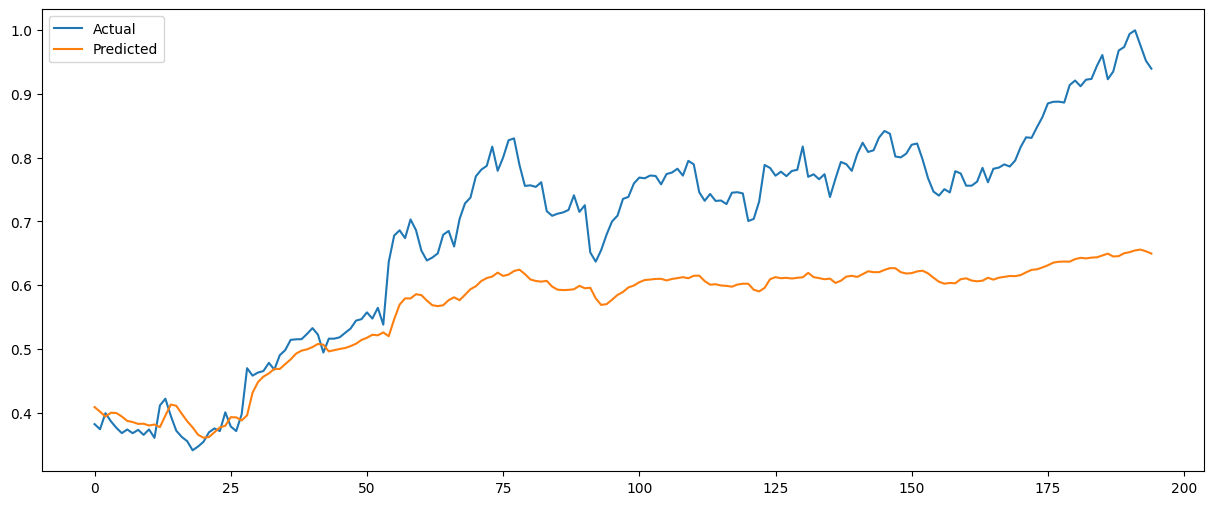

In [4]:
outputs = []
test_loss = 0
for i in range(inputs_test.shape[0]):
    x = inputs_test[i]
    x = x.unsqueeze(-1)
    output, _ = model(x)
    outputs.append(output)
    test_loss += lossfunction(output, labels_test[i].unsqueeze(-1).unsqueeze(-1))

outputs = torch.stack(outputs, dim=0).squeeze()


print(f"We got an loss of {test_loss} on our test set.")

# Plot predictions vs actual values
plt.figure(figsize=(15, 6))
plt.plot(range(len(labels_test)), labels_test.numpy(), label="Actual")
plt.plot(range(len(outputs)), outputs[:,[-1]].detach().numpy(), label="Predicted")
plt.legend()
plt.show()

torch.Size([195])
torch.Size([195, 30])
torch.Size([195, 30])


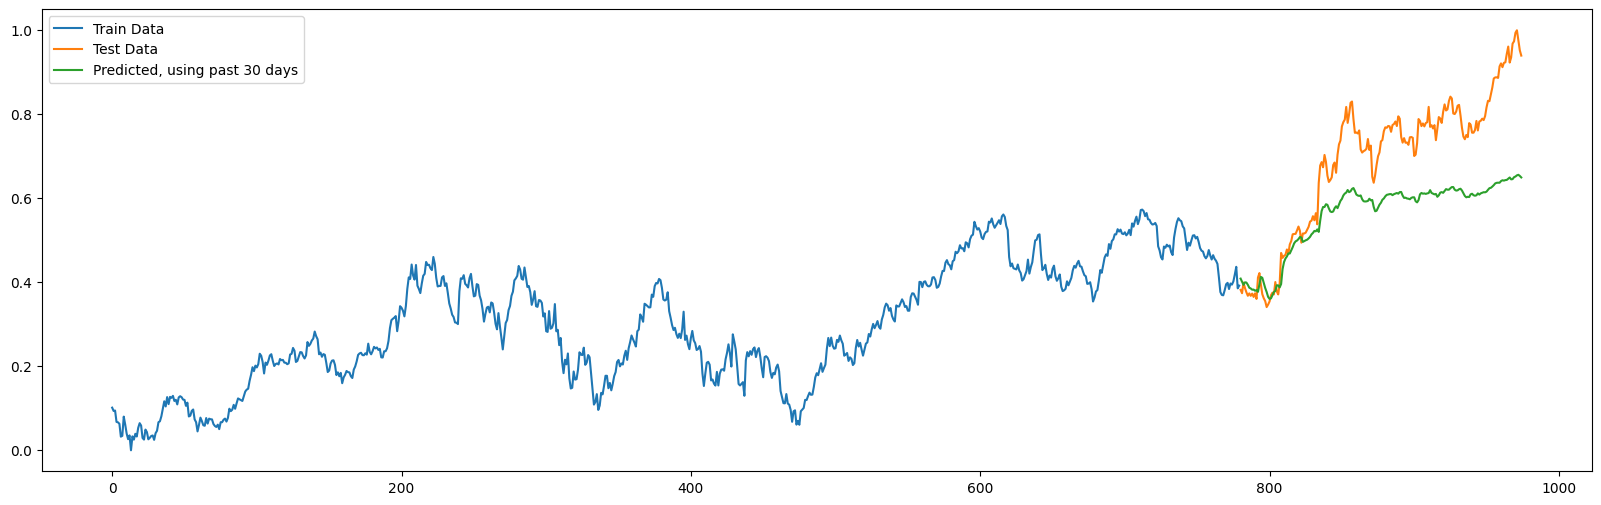

In [5]:
length_train= len(labels_train.detach().numpy())

print(labels_test.shape)
print(inputs_test.shape)
print(outputs.shape)

plt.figure(figsize=(20, 6))
plt.plot(range(length_train), labels_train.detach().numpy(), label="Train Data")
plt.plot(range(length_train, length_train+len(labels_test.detach().numpy())), labels_test.detach().numpy(), label = "Test Data")
#we take -1, as that is the sequence of values we predict to be the next value, based on the history of length seq_length we can look at, in general outputs[:, [i]] the model take the past i+1 days into account to make a prediction
plt.plot(range(length_train, length_train+len(labels_test.detach().numpy())), outputs[:,[-1]].detach().numpy(), label=f"Predicted, using past {seq_length} days")
plt.plot()
plt.legend()
plt.show() 

### Why is our Model seemingly performing well near the start, but badly near the end? 

One possible explanation for that, is that the so-called vanishing/exploding gradient problem. Let's loosely recall what this means, let $\mathcal{L}_\theta$ be our RNN and $W_{h,h}$ our weight matrix between hidden states and $x$ some sequence, then, we want to calculate our loss. By the sequential design of our RNN, since it is essentially seq_length deep, we have  $$\frac{\partial \mathcal{L}_\theta}{\partial W_{h,h}} = \sum\limits_{i = 0}^{\text{seqlength}} \frac{\partial \mathcal{L}_\theta}{\partial h_i} \cdot \frac{\partial h_i}{\partial W_{h,h}} =\sum\limits_{i = 0}^{\text{seqlength}} \frac{\partial \mathcal{L}_\theta}{\partial h_i} \cdot \prod\limits_{k = i}^{\text{seqlength}-1} \frac{\partial h_{k+1}}{\partial h_k} \cdot \frac{\partial h_k}{\partial W_{h,h}}$$

Through this repeated multiplication, we have that the loss either tends to zero, or to infty causing exploding or vanishing gradients in the early layers (i.e early time steps) since they see the most multiplications. For that, see the second plot below, as we can see, the gradients in the 0-th Layer are exploding and the gradients in the other layers are much more stable. 

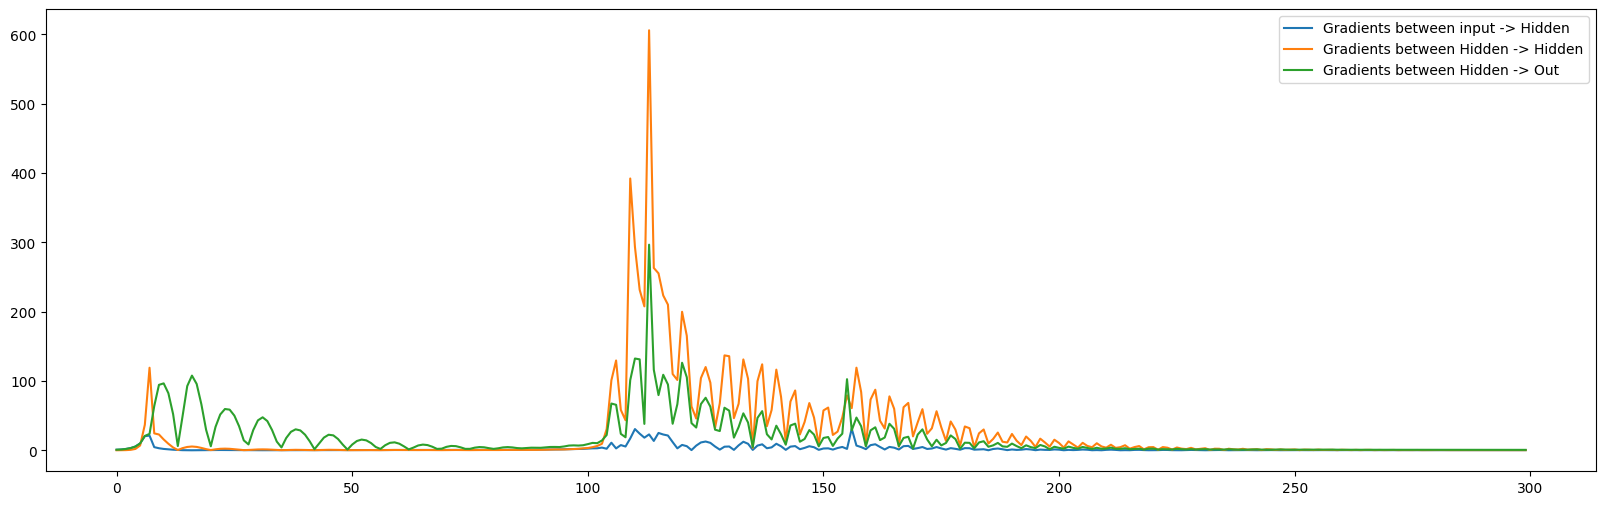

In [6]:
plt.figure(figsize=(20,6))
plt.plot(range(len(in_hidden_gradients)), in_hidden_gradients, label= "Gradients between input -> Hidden")
plt.plot(range(len(in_hidden_gradients)), hidden_hidden_gradients, label= "Gradients between Hidden -> Hidden")
plt.plot(range(len(in_hidden_gradients)), hidden_out_gradients, label= "Gradients between Hidden -> Out")
plt.legend()
plt.show()

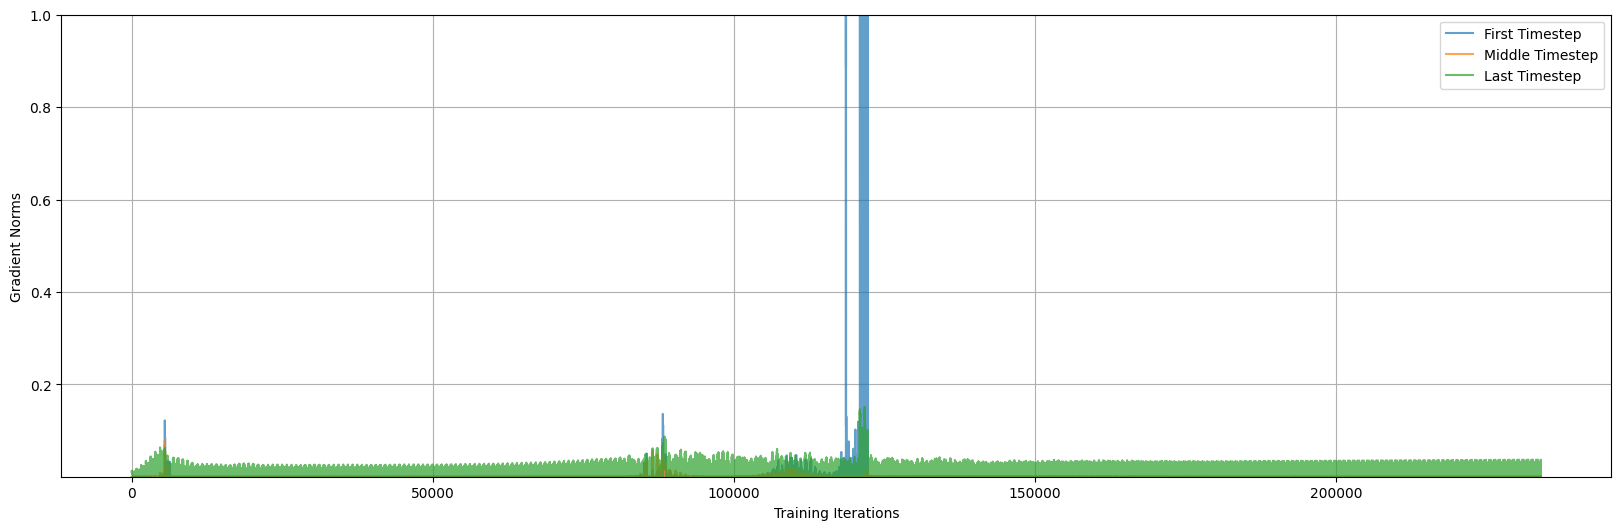

In [21]:
plt.figure(figsize=(20, 6))
plt.plot(model.begin_grad, label="First Timestep", alpha=0.7)
plt.plot(model.middle_grad, label="Middle Timestep", alpha=0.7)
plt.plot(model.end_grad, label=f"Last Timestep ", alpha=0.7)
plt.xlabel("Training Iterations")
plt.ylabel("Gradient Norms")
plt.legend()
plt.ylim(1e-8, 1)  # clipping, for better visualisation
plt.grid(True)
plt.show()